In [1]:
import numpy as np
import pandas as pd
import os
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
from datetime import timedelta
from time import time
from datetime import datetime
from tqdm import tqdm, tqdm_notebook
from datetime import datetime
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from keras.models import Input, Model, model_from_json
from keras.layers import LSTM, Dense, TimeDistributed, Embedding, Reshape, Concatenate, Bidirectional
from keras import backend as K

Using TensorFlow backend.


In [2]:
#Retrieves the import filepath.
def CreatePathName(dir1='', dir2='', dir3='', dir4='', filename=''):
    '''Directory generator function.

    Args:
        dir1: Parent direrctory name if exists.
        dir2: First Child direrctory name if exists.
        dir3: Second Child direrctory name if exists.
        dir4: Third Child direrctory name if exists.
        filename: Filname  if exists with the extension.

    Returns:
        Absolute path.
    '''
    path = os.path.join(os.path.dirname(os.path.realpath(__name__)), dir1, dir2, dir3, dir4, filename)
    return path

In [3]:
#Joins filepath with filename and changes the working directory.
csvFilesPath = CreatePathName(os.pardir, 'input')
os.chdir(csvFilesPath)
print(os.getcwd())

C:\DATA\DATA\ANN_python\Projects_to_Investigate\HEC\input


In [4]:
#Printing first 2 and last row of df.
dfAEP = (pd.read_csv(filepath_or_buffer=os.listdir(csvFilesPath)[0], 
                                     index_col=0, 
                                     header=0, 
                                     parse_dates=True)).sort_index()
print("Dataframe {} \n {} \n\n has {} rows.".format("dfAEP", dfAEP.iloc[[0,1,-1]], dfAEP.shape[0]))

Dataframe dfAEP 
                       AEP_MW
Datetime                    
2004-10-01 01:00:00  12379.0
2004-10-01 02:00:00  11935.0
2018-08-03 00:00:00  14809.0 

 has 121273 rows.


Let's rename the AEP_MW column "Cons".

In [5]:
#Rename the column of all dfs to Cons.
dfAEP.rename(columns=lambda x: 'Cons', inplace=True)

In [6]:
def checkNegativeOrZeroValues (df, column):
    '''
    Descriptioin:
        Prints the number of zero or negative values, and returns the index of such row in case of non-zero result.
        If no zero value, returns nothing.
        
    Args:
        df: Data Frame to look in.
        column: the column in which the 0 or negative value is checked. 
    
    Returns:
        list of 0 indices in df. 
        
    Revisions:
        E.Khachatryan 2020-06-06
    '''
    indicesOfZeros = []
    noOfZeros = len(df.loc[df[column]<=0, column].values.tolist())
    if noOfZeros==0:
        return print("There is no 0 or negative value in the df")
    elif noOfZeros>0:
        print("There are '{}' negative or zero values in the df".format(noOfZeros))
        indicesOfZeros = df.index[df[column] <= 0].values.tolist()
        return indicesOfZeros
    else:
        raise Exception("Number of rows couldn't be negative: {}".format(noOfZeros))
         
########################################################################################
def checkMissingValues(df):
    '''
    Descriptioin:
        Prints the number of missing (null) values, and returns the index of such row in case of non-zero result.
        If no zero value, returns nothing.
        
    Args:
        df: Data Frame to look in.
            
    Returns:
        list of 0 indices in df. 
        
    Revisions:
        E.Khachatryan 2020-06-07   
    '''
    nullRows = df.isnull().any(axis=1)
    sumOfNullContainingRows = sum(nullRows)
    if sumOfNullContainingRows == 0:
        print("Data Frame has no missing values.")
    else:
        print("Data Frame has {} missing value(s).".format(sumOfNullContainingRows))
        return df[nullRows].index.values

In [7]:
checkNegativeOrZeroValues(dfAEP, 'Cons')
checkMissingValues(dfAEP)

There is no 0 or negative value in the df
Data Frame has no missing values.


### Feature engineering
#### Predictor Variable

In [8]:
#Adding day of week and day of week and hour.
# def getWeekDay(timestamp):
#     weekday = timestamp.weekday()
#     return weekday

def addHoursToWDays(timestamp):
    weekdayHour = str(timestamp.weekday()) + '_' + timestamp.strftime("%H")
    return weekdayHour

In [9]:
weekDayHour = []
for i in range(dfAEP.shape[0]):
    weekDayHour.append(addHoursToWDays(dfAEP.index[i]))
dfAEP['WeekDayHour'] = weekDayHour
print(dfAEP.head())

                        Cons WeekDayHour
Datetime                                
2004-10-01 01:00:00  12379.0        4_01
2004-10-01 02:00:00  11935.0        4_02
2004-10-01 03:00:00  11692.0        4_03
2004-10-01 04:00:00  11597.0        4_04
2004-10-01 05:00:00  11681.0        4_05


In [10]:
#Defining the function to add the average consumption based on weekday+hour combination.
def addAvgConsUsingWeekdayHour(dataFrame, grByCriteriaCol, sourceCol, targetCol, RowsToCount, roundLevel=1):
    if (grByCriteriaCol == sourceCol or grByCriteriaCol==targetCol):
        raise Exception('Group by Criteria Column cannot be the same as Source Column or Target Column.')
    dataFrame[targetCol] = dataFrame.loc[:,grByCriteriaCol]\
                                            .replace(dataFrame.iloc[:RowsToCount,:]\
                                                     .groupby(grByCriteriaCol)[sourceCol]\
                                                         .mean()\
                                                             .round(roundLevel)\
                                                                 .to_dict())

#Adding meanCons column that contains the average consumption by weekday and hour.    
Rows = 24*365
addAvgConsUsingWeekdayHour(dfAEP, 'WeekDayHour', 'Cons', 'meanCons', Rows)
print(dfAEP.head())

                        Cons WeekDayHour  meanCons
Datetime                                          
2004-10-01 01:00:00  12379.0        4_01   14338.4
2004-10-01 02:00:00  11935.0        4_02   13787.9
2004-10-01 03:00:00  11692.0        4_03   13486.3
2004-10-01 04:00:00  11597.0        4_04   13369.5
2004-10-01 05:00:00  11681.0        4_05   13513.9


In [11]:
#Creating a function to standardize the target column.
def addStandardizedColumn(dataFrame, sourceCol, meanCol, targetCol):
    dataFrame[targetCol] = (np.log(dataFrame.loc[:, sourceCol]) - np.log(dataFrame.loc[:, meanCol]))
    
addStandardizedColumn(dfAEP, 'Cons', 'meanCons', 'logdiffConsAndMeanCons')

(dfAEP.head())

,Cons,WeekDayHour,meanCons,logdiffConsAndMeanCons
Datetime,,,,
2004-10-01 01:00:00,12379.0,4_01,14338.4,-0.146940
2004-10-01 02:00:00,11935.0,4_02,13787.9,-0.144316
2004-10-01 03:00:00,11692.0,4_03,13486.3,-0.142770
2004-10-01 04:00:00,11597.0,4_04,13369.5,-0.142230
2004-10-01 05:00:00,11681.0,4_05,13513.9,-0.145755


In [12]:
#########################

In [13]:
# def reverseStandardizedColumn(dataFrame, sourceCol, meanCol, targetCol):
#     #dataFrame[targetCol] = np.exp((dataFrame.loc[:, sourceCol]) + np.log(dataFrame.loc[:, meanCol]))
#     dataFrame[targetCol] = np.exp((dataFrame.loc[:, sourceCol]) + np.log(dataFrame.loc[:, meanCol]))
    
# reverseStandardizedColumn(dataFrame=dfAEP, sourceCol='logdiffConsAndMeanCons', meanCol='meanCons', targetCol='reversed')
# dfAEP.head()

In [14]:
##################

#### Exploratory visualizations

In [15]:
def createPlotConsumption (x_col, y_col, variable_label, chart_title, x_label, y_label):
    '''
    DESCRIPTION:
        Create a plot for total consumption.

    Args:
        x_col: X axes
        y_col: Y axes
        variable_label: The name of target variable.
        chart_title: Title of the chart.
        x_label: x axis label name.
        y_label: y axis label name.

    Returns:
        A list of Line2D objects representing the plotted data.
    '''

    # Create a plot.
    sns.set()
    figTotalCons = plt.figure(figsize = (18,6))
    sns.lineplot(x=x_col,
                 y=y_col,
                 label=variable_label,
                 legend="full")

    # Add labels.
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel(y_label, fontsize=16)
    
    plt.ylim(ymin=0, ymax=1.1*max(y_col))

    # Add a title.
    chart_title = chart_title
    plt.title(chart_title, fontsize=20, fontweight="bold")
    return plt

In [16]:
def createPlotConsumption (x_col, y_col1, variable_label1, chart_title, x_label, y_label, 
                           y_col2=None, low_10=None, up_90=None, variable_label2=None):
    '''
    DESCRIPTION:
        Create a plot for total consumption.

    Args:
        x_col: X axes
        y_col: Y axes
        variable_label: The name of target variable.
        chart_title: Title of the chart.
        x_label: x axis label name.
        y_label: y axis label name.

    Returns:
        A list of Line2D objects representing the plotted data.
    '''

    # Create a plot.
    sns.set()
    figTotalCons = plt.figure(figsize = (18,6))
    sns.lineplot(x=x_col, y=y_col1, label=variable_label1, legend="full")
    if y_col2 is not None:
        sns.lineplot(x=x_col, y=y_col2, label=variable_label2, legend="full")
        plt.ylim(ymin=0, ymax=1.2*max(max(y_col1), max(up_90)))
        plt.fill_between(x_col, low_10, up_90, alpha=0.2, 
                 edgecolor='#1B2ACC', facecolor='#089FFF', linewidth=1, linestyle='dashdot', antialiased=True)
    else:
        plt.ylim(ymin=0, ymax=1.2*max(y_col1))

    # Add labels.
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel(y_label, fontsize=16)
    
    # Add a title.
    chart_title = chart_title
    plt.title(chart_title, fontsize=20, fontweight="bold")
    return plt

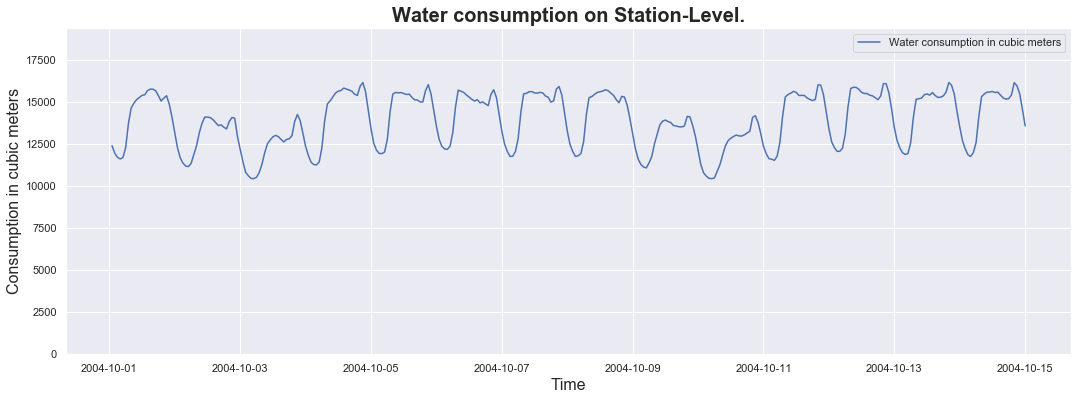

In [17]:
createPlotConsumption(dfAEP.iloc[0:24*14].index, 
                      dfAEP.iloc[0:24*14, 0], 
                      "Water consumption in cubic meters", 
                      "Water consumption on Station-Level.",
                      "Time",
                      "Consumption in cubic meters",  y_col2=None, variable_label2=None)
plt.show()

In [18]:
x_col = dfAEP.iloc[0:24*14].index
y_col = dfAEP.iloc[0:24*14, 0]

In [19]:
#TODO: add param for range(0, numElements-totalSeqLen+1, 1). 1 should be configurable.

def generateMultiStepModelInput(dataFrame, totalSeqLen, ySeqLen, col):
    '''
    Generates X and Y sets from dataframe's column.
    
    Args:
        dataFrame: Data Frame to look at.
        totalSeqLen: The predictor and response variables sequence length combined.
        ySeqLen: The response variable sequence lengt.
        col: The column to look at.
        
    Returns:
        2 lists: 1st X list with the dimensions of: ((df total rows-totalSeqLen+1), 
                                                            totalSeqLen-ySeqLen, 
                                                            1)
                 2nd Y list with the dimensions of: ((df total rows-totalSeqLen+1),
                                                        ySeqLen)

    Revision:
        June 06, 2020 created (Edgar Khachatryan)
    '''
    dataMatrix = dataFrame[col]
    numElements = dataMatrix.shape[0]
    
    indices = dataFrame.index.values

    for _, stop in zip(range(0, numElements-totalSeqLen+1, 1), 
                       range(totalSeqLen, numElements+1, 1)):
        
        yield dataMatrix[(stop-totalSeqLen):stop-ySeqLen].values.reshape((-1,len(col))), \
              dataMatrix[stop-ySeqLen:stop].values.reshape((-1))

In [20]:
sequenceLength = 7*24

X, Y = [], []
totalSequenceLength = 5*7*24 #Total 5 weeks,use 4 weeks data to forecast 1 week foreward.
ySequenceLength = 7*24


for i in generateMultiStepModelInput(dfAEP, totalSequenceLength, ySequenceLength, ['logdiffConsAndMeanCons']):
    x, y = i
    X.append(x)
    Y.append(y)
X = np.asarray(X)
Y = np.asarray(Y)

In [21]:
print(X.shape, Y.shape)

(120434, 672, 1) (120434, 168)


In [22]:
losses = [lambda y,f: K.mean(K.maximum(0.1*(y-f), (0.1-1)*(y-f)), axis=-1), 
         lambda y,f: K.mean(K.maximum(0.5*(y-f), (0.5-1)*(y-f)), axis=-1), 
         lambda y,f: K.mean(K.maximum(0.9*(y-f), (0.9-1)*(y-f)), axis=-1)]

# SECOND version.

In [23]:
#Model uses 4 weeks of data (672 hours) to predict next 7 days (168 hours) of consumption.

In [24]:
trainLength = 168*52
X_Train, y_Train = X[0:trainLength], Y[0:trainLength]

In [25]:
X_Test, y_Test = X[trainLength:2*trainLength], Y[trainLength:2*trainLength]

In [26]:
print("The input shape of data is {}, {} and {}. \nThe output shape is {}, {}.".format(X_Train.shape[0], X_Train.shape[1], X_Train.shape[2],  y_Train.shape[0], y_Train.shape[1]))

The input shape of data is 8736, 672 and 1. 
The output shape is 8736, 168.


In [27]:
inputs = Input(shape=(X_Train.shape[1], X_Train.shape[2]))
lstm = Bidirectional(LSTM(32, return_sequences=True, dropout=0.3))(inputs, training = True)
lstm = Bidirectional(LSTM(16, return_sequences=False, dropout=0.3))(lstm, training = True)

dense = Dense(50)(lstm)

out10 = Dense(y_Train.shape[1])(dense)
out50 = Dense(y_Train.shape[1])(dense)
out90 = Dense(y_Train.shape[1])(dense)

model = Model(inputs, [out10,out50,out90])

model.compile(loss=losses, optimizer='adam', loss_weights = [0.3,0.3,0.3])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 672, 1)       0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 672, 64)      8704        input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 32)           10368       bidirectional_1[0][0]            
__________________________________________________________________________________________________
dense_1 (Dense)      

In [28]:
#Pretrain the model.
# EPOCHS = 10
# history = model.fit(X_Train, [y_Train, y_Train, y_Train], epochs=EPOCHS, batch_size=548, verbose=2, shuffle=True)

In [32]:
# Change working directory to ../Models.
modelPath = CreatePathName(os.pardir, 'models')
os.chdir(modelPath)
print(os.getcwd())

C:\DATA\DATA\ANN_python\Projects_to_Investigate\HEC\models


In [33]:
# Save model to .json format.
modelSaveJson = model.to_json()
with open("LSTMModel.json", "w") as json:
    json.write(modelSaveJson)

# Save weights to HDF5
model.save_weights("LSTMModelWeights.h5")

# Save the optimizer value
optimizerWeights = getattr(model.optimizer, 'weights')
weights = K.batch_get_value(optimizerWeights)
with open('optimizer.pkl', 'wb') as f:
    pickle.dump(weights, f)

In [34]:
# Load model from .json file.
LSTMModelFile = open("LSTMModel.json", "r")
modelReader = LSTMModelFile.read()
LSTMModelFile.close()
model = model_from_json(modelReader)

# Compile the model and print.
model.compile(loss=losses, optimizer='adam', loss_weights = [0.3,0.3,0.3])
model.summary()

# Load weights to the loadedModel from .hdf5 file to predict.
model.load_weights("LSTMModelWeights.h5")

# Load optimizer weights to comtinue training.
model._make_train_function()
with open('optimizer.pkl', 'rb') as f:
    weightValues = pickle.load(f)
model.optimizer.set_weights(weightValues)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 672, 1)       0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 672, 64)      8704        input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 32)           10368       bidirectional_1[0][0]            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 50)           1650        bidirectional_2[0][0]            
__________________________________________________________________________________________________
dense_2 (D

In [35]:
#Pretrain the model.
# EPOCHS = 2
# history = model.fit(X_Train, [y_Train, y_Train, y_Train], epochs=EPOCHS, batch_size=548, verbose=2, shuffle=True)

In [36]:
###LOADED MODEL QUANTILEs BOOTSTRAPPING ###
#1 prediction.
yHat10, yHat, yHat90 = [], [], []
NN = K.function([model.layers[0].input, K.learning_phase()], 
                [model.layers[-3].output,model.layers[-2].output,model.layers[-1].output])

for i in tqdm_notebook(range(0,100)):
    predd = NN([X_Test[0:100], 0.5])
    yHat10.append(predd[0])
    yHat.append(predd[1])
    yHat90.append(predd[2])
    
yHat10 = np.quantile(yHat10, 0.1, axis=0)
yHat = np.asarray(yHat).mean(axis=0)
yHat90 = np.quantile(yHat90, 0.9, axis=0)

In [37]:
def reverseStandardizedValue(YTestRowIndex, YTestColIndex, 
                             XTrainShape0, XTrainShape1,
                             sourceDF, meanCol, souceVal):
    '''
    YTestRowIndex, YTestColIndex: Index of row and column, by 1 less than XTrainShape0, XTrainShape1.
    '''
    meanVal = sourceDF.loc[ sourceDF.index[ YTestRowIndex + YTestColIndex
                                           + XTrainShape0 + XTrainShape1 ],
                            meanCol ]
    
    return np.exp(souceVal + np.log(meanVal))

def returnRowIndex(YTestRowIndex, YTestColIndex, 
                   XTrainShape0, XTrainShape1,
                   sourceDF):
    index = sourceDF.index[ YTestRowIndex + YTestColIndex
                          + XTrainShape0 + XTrainShape1 
                          ]
    return index

# Returns row index from df.
# for i in range(Y.shape[0]):
#     for j in range(Y.shape[1]):
#         print(returnRowIndex(i, j, X.shape[1], dfAEP))

# Returns row index from df.
# for i in range(Y.shape[0]):
#     for j in range(Y.shape[1]):
#         print(reverseStandardizedValue(i, j, X.shape[1], dfAEP, 'meanCons', Y[i,j]))

In [38]:
#Reverse the forecasts.
prediction = []
for i in range(100):
    prediction.append([])    
    for j in range(yHat.shape[1]):
        prediction[i].append(reverseStandardizedValue(i, 
                         j, 
                         X_Train.shape[0], 
                         X_Train.shape[1],  
                         dfAEP, 
                         'meanCons', 
                         yHat[i][j]))
prediction = np.asarray(prediction)


prediction10 = []
for i in range(100):
    prediction10.append([])
    for j in range(yHat10.shape[1]):
        prediction10[i].append(reverseStandardizedValue(i, 
                         j, 
                         X_Train.shape[0], 
                         X_Train.shape[1],  
                         dfAEP, 
                         'meanCons', 
                         yHat10[i][j]))
prediction10 = np.asarray(prediction10)

prediction90 = []
for i in range(100):
    prediction90.append([])
    for j in range(yHat90.shape[1]):
        prediction90[i].append(reverseStandardizedValue(i, 
                         j, 
                         X_Train.shape[0], 
                         X_Train.shape[1],  
                         dfAEP, 
                         'meanCons', 
                         yHat90[i][j]))
prediction90 = np.asarray(prediction90)

In [39]:
#Create array of actual test values.
actual = []
for i in range(100):
    actual.append([])
    for j in range(y_Test.shape[1]):
        actual[i].append(reverseStandardizedValue(i, 
                         j, 
                         X_Train.shape[0], 
                         X_Train.shape[1],  
                         dfAEP, 
                         'meanCons', 
                         y_Test[i][j]))
actual = np.asarray(actual)

# # Retriveing the actual consumption data for the predicted period from dataframe.
# predStartIndex = returnRowIndex(0, 0, X_Train.shape[0], X_Train.shape[1], dfAEP)
# predEndIndex = returnRowIndex(yHat.shape[0]-1, yHat.shape[1]-1, X_Train.shape[0], X_Train.shape[1], dfAEP)
# actual = dfAEP.loc[predStartIndex:predEndIndex, 'Cons'].values

In [40]:
#Create array of indices for plotting.
index = []
for i in range(100):
    index.append([])
    for j in range(yHat.shape[1]):
        index[i].append(returnRowIndex(i, 
                                    j, 
                                    X_Train.shape[0], 
                                    X_Train.shape[1],  
                                    dfAEP))
index = np.asarray(index)

In [41]:
print(prediction.shape, prediction10.shape, prediction90.shape, actual.shape, index.shape)

(100, 168) (100, 168) (100, 168) (100, 168) (100, 168)


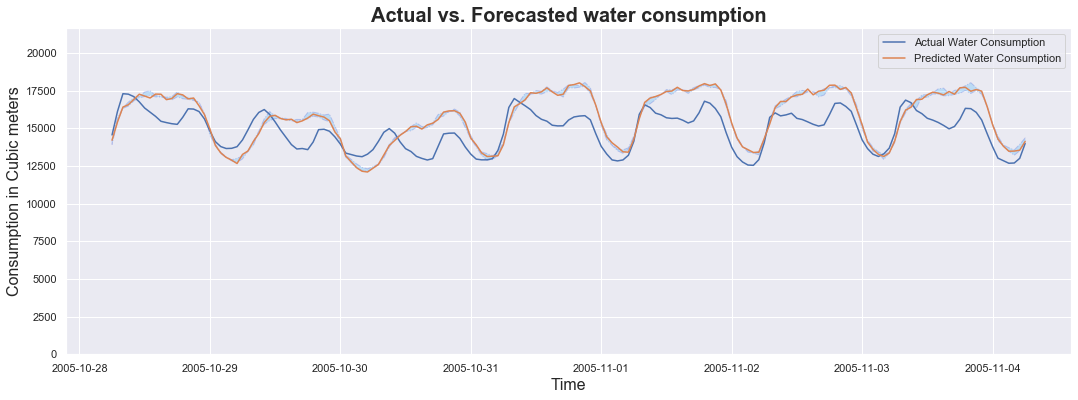

In [42]:
createPlotConsumption(index[3], actual[3], "Actual Water Consumption", "Actual vs. Forecasted water consumption", "Time", 
                      "Consumption in Cubic meters", 
                      prediction[3], prediction10[3], prediction90[3], "Predicted Water Consumption" )
plt.show()

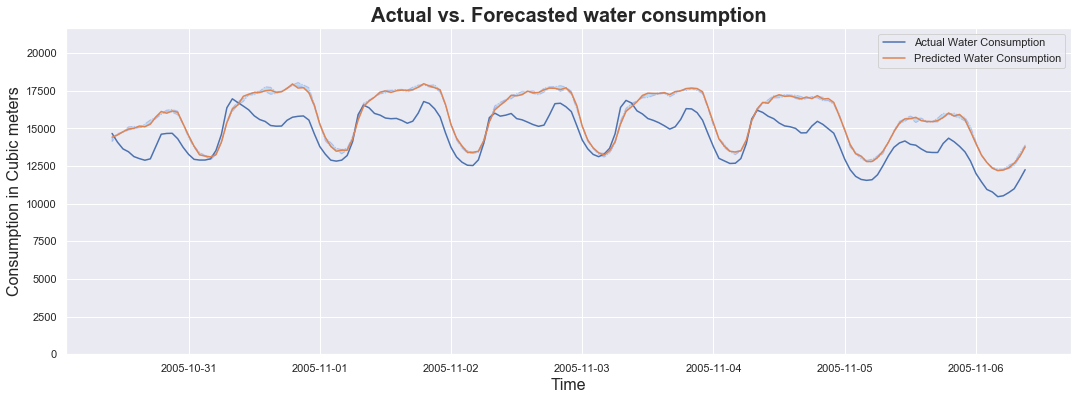

In [43]:
createPlotConsumption(index[54], actual[54], "Actual Water Consumption", "Actual vs. Forecasted water consumption", "Time", 
                      "Consumption in Cubic meters", 
                      prediction[54], prediction10[54], prediction90[54], "Predicted Water Consumption" )
plt.show()

#### Evaluate the model.

In [44]:
def MAPE(yActual, yPrediction): 
    """
    Calculates MAPE given y_true and y_pred
    """
    yActual, yPrediction = np.asarray(yActual), np.asarray(yPrediction)
    return np.mean(np.abs((yActual - yPrediction) / yActual)) * 100

In [45]:
actual.shape

(100, 168)

In [46]:
MAPE(actual, prediction)

9.238062087339847

In [47]:
mapes = []
for i in range(100):
    mapes.append(MAPE(actual[i], prediction[i]))

In [48]:
##PLotting experiment.

In [56]:
#t = np.asarray([returnRowIndex(0, k, X_Train.shape[0], X_Train.shape[1], dfAEP) for k in range(yHat.shape[1])])
#alternative t
t = np.linspace(0,200)
x = np.asarray([reverseStandardizedValue(0, k, X_Train.shape[0], X_Train.shape[1], dfAEP, 'meanCons', yHat[0][k]) for k in range(yHat.shape[1])])

In [57]:
# t = np.linspace(0,200)
# x = np.asarray(actual)

<IPython.core.display.Javascript object>


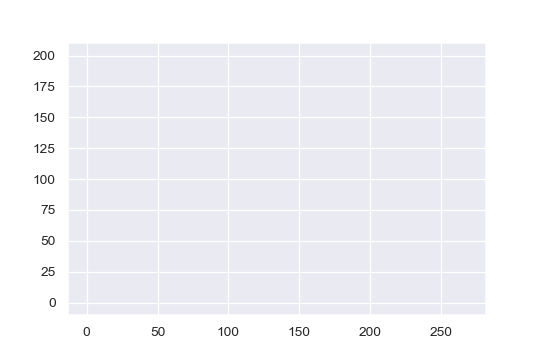

In [59]:
%matplotlib notebook
import matplotlib.animation

# t = np.linspace(0,2*np.pi)
# x = np.sin(t)

fig, ax = plt.subplots()
l, = ax.plot([0, 268],[0, 200])

animate = lambda i: l.set_data(t[:i], x[:i])
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t))
plt.show()

In [60]:
########

In [61]:
# %matplotlib notebook
# from datetime import datetime
# from matplotlib import pyplot
# from matplotlib.animation import FuncAnimation
# from random import randrange

# x_data, y_data = [], []

# figure = pyplot.figure()
# line, = pyplot.plot_date(x_data, y_data, '-')
# #x_data = [reverseStandardizedValue(0, k, X_Train.shape[0], X_Train.shape[1], 
# #                                         dfAEP, 'meanCons', yHat[0][k]) for k in range(yHat.shape[1])]

# def update(frame):
#     x_data.append(datetime.now())
#     y_data.append(randrange(0, 100))
#     line.set_data(x_data, y_data)
#     figure.gca().relim()
#     figure.gca().autoscale_view()
#     return line,

# animation = FuncAnimation(figure, update, interval=200)

# pyplot.show()

In [62]:
################

In [63]:
# # Plotting the actual and predicted values.
# plt.figure(figsize=(20,10))
# plt.plot(actual, color='red', alpha=0.4, label="Actual")
# plt.plot(predictions, color='blue', alpha=0.4, label="Prediction")
# #plt.fill_between(x_axis, pred_50_m-lower_coridor, pred_50_m + upper_coridor, alpha=0.2, 
# #                 edgecolor='#1B2ACC', facecolor='#089FFF', linewidth=1, linestyle='dashdot', antialiased=True)

# plt.xlabel('Hours')
# plt.ylabel('Station level consumption in cubic meters (m3)')
# plt.title('LSTM prediction for 133 days')
# #plt.scatter(range(len(pred_10_m)), pred_90_m - pred_10_m)
# plt.axis([-5, max(actual.shape[0], predictions.shape[0])+5, 0, 18000])
# plt.grid(True)

In [64]:
# ### PLOT UNCERTAINTY INTERVAL LENGHT WITH REAL DATA ###

# plt.figure(figsize=(16,12))
# plt.plot(np.exp(y_test1+init[364:]), color='red', alpha=0.4, label="Actual")
# plt.plot(pred_50_m, color='blue', alpha=0.4, label="Prediction")
# plt.fill_between(x_axis, pred_50_m-lower_coridor, pred_50_m + upper_coridor, alpha=0.2, 
#                  edgecolor='#1B2ACC', facecolor='#089FFF', linewidth=1, linestyle='dashdot', antialiased=True)

# plt.xlabel('Days')
# plt.ylabel('Station level consumption in cubic meters (m3)')
# plt.title('LSTM prediction for 133 days')
# plt.scatter(range(len(pred_10_m)), pred_90_m - pred_10_m)
# plt.axis([-5, 140, 0, 7000])
# plt.grid(True)

In [65]:
# #Getting the last value of X[0] from dataframe.
# print(dfAEP.index[X.shape[1]-1], dfAEP.loc[dfAEP.index[X.shape[1]-1],'logdiffConsAndMeanCons'])
# print(X[0][-1])

# #Getting the first value of Y[0][0] from dataframe.
# print(dfAEP.index[X.shape[1]], dfAEP.loc[dfAEP.index[X.shape[1]],'logdiffConsAndMeanCons'])
# print(Y[0][0])

# #Getting the last value of Y[0][-1] from dataframe.
# print(dfAEP.index[X.shape[1]+Y.shape[1]-1], dfAEP.loc[dfAEP.index[X.shape[1]+Y.shape[1]-1],'logdiffConsAndMeanCons'])
# print(Y[0][-1])

# #Getting the first value of Y[1] from dataframe.
# print(dfAEP.index[X.shape[1]+1], dfAEP.loc[dfAEP.index[X.shape[1]+1],'logdiffConsAndMeanCons'])
# #Getting the second row's first value from Y.
# print(Y[1][0])

# #Getting the meanConsumption from dataframe.
# print(dfAEP.index[X.shape[1]+1], dfAEP.loc[dfAEP.index[X.shape[1]+1], 'meanCons'])


# #Getting the first value of Y[120433][0] from dataframe.
# print(dfAEP.index[X.shape[1]+120433+167], dfAEP.loc[dfAEP.index[X.shape[1]+120433+167],'logdiffConsAndMeanCons'])
# #Getting the second row's first value from Y.
# print(Y[120433][167])

# #Getting the first value of Y[120433][0] from dataframe.
# print(dfAEP.index[X.shape[1]+0+2], dfAEP.loc[dfAEP.index[X.shape[1]+0+2],['logdiffConsAndMeanCons', 'Cons']])
# #Getting the second row's first value from Y.
# print(Y[120433][167])

# #Getting the first value of Y[0][0] from dataframe.
# print(dfAEP.index[X.shape[1]+0+1], dfAEP.loc[dfAEP.index[X.shape[1]+0+1],['logdiffConsAndMeanCons', 'Cons']])
# #Getting the second row's first value from Y.
# print(Y[0][0])